In [3]:
from pscore_data_reader_preproc import read_and_process_data, model_evaluation
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [23]:
# Read in the data using the pre-processing code
x_train, y_train, x_test, y_test, train_team_values, test_team_values = read_and_process_data(
     r"E:\github_repos\Private_Projects\NCAA_FBS_AP_Ranking_Predictions\python_ap\scripts_and_data\data\score_pred_train_data.csv",
     r"E:\github_repos\Private_Projects\NCAA_FBS_AP_Ranking_Predictions\python_ap\scripts_and_data\data\score_pred_test_data.csv",
     True
)

# check to make sure the data looks right
x_train.shape
x_test.shape

train data has shape: (14648, 490)
test data has shape: (132, 490)


(132, 490)

In [22]:
# Step 1: Define hyperparameter grid
n_neighbors_values = range(1, 30)  # Number of neighbors to consider
weights_values = ['uniform', 'distance']  # Uniform or distance-based weighting
p_values = [1, 2]  # Distance metric: 1 for Manhattan, 2 for Euclidean

# Step 2: Create the parameter grid
knn_param_grid = {
    'n_neighbors': n_neighbors_values,
    'weights': weights_values,
    'p': p_values
}

# Step 3: set up regressor
knn_regressor = KNeighborsRegressor()

# Step 4: fit the grid search model
knn_grid_search = GridSearchCV(
    estimator=knn_regressor,
    param_grid=knn_param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',  # Use negative MSE as the scoring metric
    n_jobs=-3,  # Use all available cores minus 2
    verbose=1  # Output progress
)

In [8]:
# fit the grid search
knn_grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 116 candidates, totalling 580 fits


GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-3,
             param_grid={'n_neighbors': range(1, 30), 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error', verbose=1)

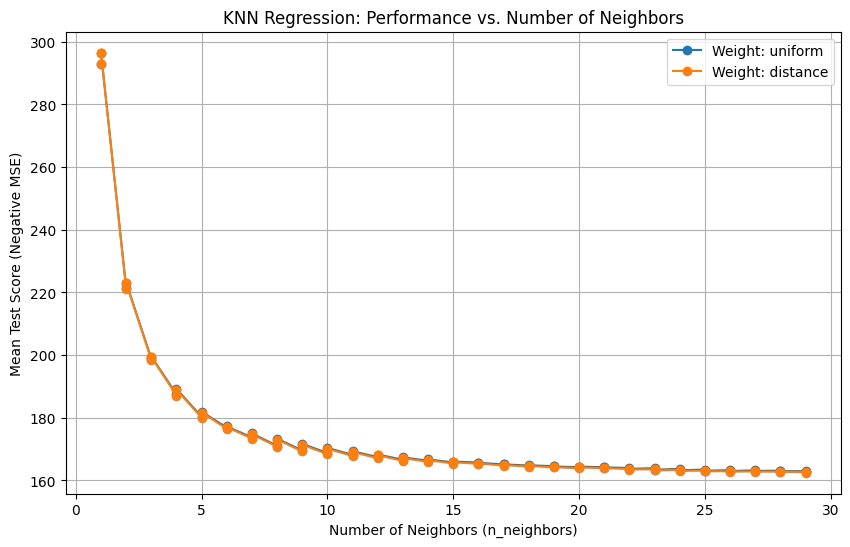

In [9]:
# Extract results from GridSearchCV
knn_results = pd.DataFrame(knn_grid_search.cv_results_)

# Plot performance for different n_neighbors grouped by weights
plt.figure(figsize=(10, 6))

for weight in weights_values:  # weights: ['uniform', 'distance']
    subset = knn_results[knn_results['param_weights'] == weight]
    plt.plot(
        subset['param_n_neighbors'], 
        -subset['mean_test_score'],  # Negative MSE to positive MSE
        marker='o', 
        label=f'Weight: {weight}'
    )

# Customize plot
plt.xlabel('Number of Neighbors (n_neighbors)')
plt.ylabel('Mean Test Score (Negative MSE)')
plt.title('KNN Regression: Performance vs. Number of Neighbors')
plt.legend()
plt.grid()
plt.show()

In [10]:
# Get the best paramaters 
best_n_neighbors_value = knn_grid_search.best_params_['n_neighbors']
best_weights_value = knn_grid_search.best_params_['weights']
best_p_value = knn_grid_search.best_params_['p']

# Print the best values
print(f"Best n_neighbors: {best_n_neighbors_value}")
print(f"Best weights: {best_weights_value}")
print(f"Best p: {best_p_value}")

Best n_neighbors: 29
Best weights: distance
Best p: 2


In [11]:
# fit final model using the best param
best_knn_regressor = KNeighborsRegressor(
    n_neighbors=best_n_neighbors_value,
    weights=best_weights_value,
    p=best_p_value
)

best_knn_regressor.fit(x_train, y_train)

KNeighborsRegressor(n_neighbors=29, weights='distance')

In [12]:
# Model evaluation
y_pred_train = best_knn_regressor.predict(x_train)

# evaluate model
model_evaluation(y_train, y_pred_train)

R-squared: 1.000
Mean Squared Error (MSE): 0.000
Mean Absolute Error (MAE): 0.000


In [24]:
y_pred_test = best_knn_regressor.predict(x_test)
x_test['predictions'] = y_pred_test
x_test['actual'] = y_test
x_test = pd.concat([x_test, test_team_values], axis=1)
x_test.to_csv("dsdsdsata_test.csv")